In [22]:
import easyocr
 
image_path = 'data/images/sample.jpg'
# 言語選択（デフォルトでGPU利用、CPUのみの場合はgpu=False）
reader = easyocr.Reader(['ja','en'], )#gpu=True)
result = reader.readtext(image_path)#, detail=0)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [23]:
print(result[:5])
# print('\n'.join([r[1] for r in result]))

[([[385, 109], [475, 109], [475, 141], [385, 141]], 'Coaking', 0.7735976701269524), ([[1215, 104], [1349, 104], [1349, 147], [1215, 147]], '冷蔵保存', 0.9996437430381775), ([[1364, 110], [1462, 110], [1462, 147], [1364, 147]], '2-3日', 0.9566273093223572), ([[1492, 105], [1626, 105], [1626, 154], [1492, 154]], '冷凍保存', 0.9935353398323059), ([[1651, 114], [1731, 114], [1731, 152], [1651, 152]], '功カ月', 0.0862998217344284)]


In [24]:
# !pip install scikit-learn

In [25]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

def cluster_ocr_results(ocr_results, eps=0.4, min_samples=2):
    # Bounding boxの中心座標とテキスト情報を計算してデータを作成
    centers = []
    texts = []
    confidences = []
    for i, result in enumerate(ocr_results):
        box = result[0]
        center = np.mean(box, axis=0)
        centers.append(center)
        texts.append(result[1])
        confidences.append(result[2])
    X = StandardScaler().fit_transform(centers)

    # DBSCANによるクラスタリング
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

    # クラスタリング結果と各クラスタに含まれるテキスト情報の出力
    labels = dbscan.labels_
    print(set(labels))
    clusters = []
    for label, result in zip(labels, ocr_results):
        result_dict = {'box': result[0], 'text': result[1], 'confidence': result[2], 'label': label}
        clusters.append(result_dict)
    return clusters

clustered_result = cluster_ocr_results(result)

{0, 1, 2, 3, 4, -1}


In [26]:
clusters = {}
for r in clustered_result:
    if r['label'] not in clusters.keys():
        clusters[r['label']] = []
    clusters[r['label']].append(r)

print(clusters.keys())

recipe_text = ''
for label,cluster in clusters.items():
    for c in cluster:
        recipe_text += c['text']+'\n'
    recipe_text += '\n'

print(recipe_text)

dict_keys([0, 1, -1, 2, 3, 4])
Coaking
Time
調理時間
1Omin

冷蔵保存
2-3日
冷凍保存
功カ月
小松菜と豚バラの
塩しょうが蒸し
小松菜を1束たっぷり使って 豚バラと重ねて蒸し焼きに。
シンプルな味つけですが 最後に加えるしょうゆで香りと
コクが増し グンとおいしく!
材料(2人分)
豚バラ薄切り肉
酒大さじ3
(しゃぶしゃぶ用)
塩ひとつまみ
小松菜…1束 (2009)
しょうが(チューブ)
ごま油‥大さじ1/2
…1~Zcm
白州りごま (好みで)適量
かつお節 (あれば)1袋 (2.59)
しょうゆ 小さじ1
…2009

お弁当向け
作り方
を加えて
047

10分
~
域いた
める。
仕上
1o
器に盛
んはきの
スープの

調理POINT
代用食材
豚肉が長い場合は食べや
すい大きさに切ってください。
豚バラ薄切り肉は豚ロー
小松菜の苦味が苦手な方
ス肉や豚こま切れ肉 鶏も
は
@を加えるタイミングで白
も肉でもOKo
小松菜はち
すりごま大さじ1~2を加える
んげん菜 キャベツ 白菜
と
より食べやすくなります。
プロッコリーで代用できます。
温め直し
|ラップをかけて温めモードで電子レンジ加熱。

@小松菜は3~4C長さのざく切りにする。
フライパンにごま油をひいて中火で熱し 豚肉を州める。
の豚肉の色が8割がた変わったら小松菜を加え
フタをし 5分ほど蒸し焼きにする。
@小松菜がしんなりしたら回を加え サッと州める。 器に盛
り
好みで白州りごまをふる。




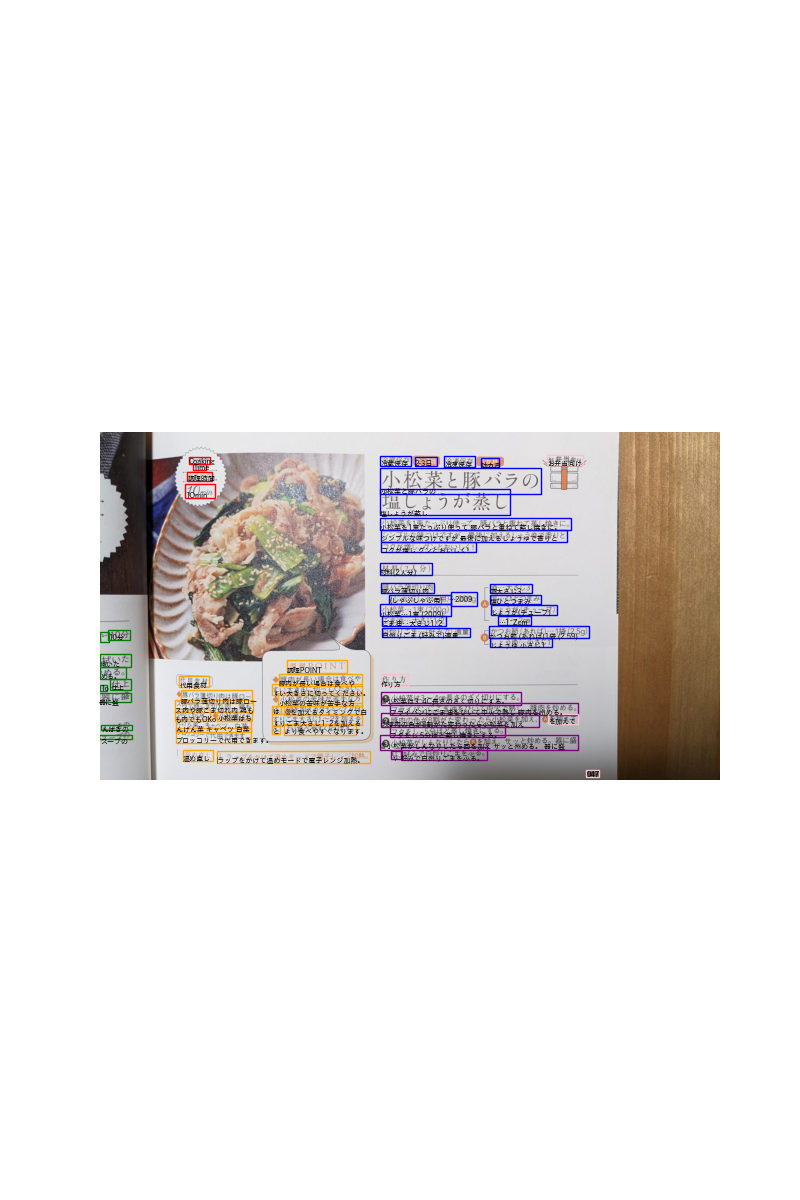

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import japanize_matplotlib
%matplotlib widget

colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']

image = Image.open(image_path)

fig = plt.figure(figsize = (8,12))
ax = plt.axes()
ax.imshow(image)
ax.axis("off")
for t in clustered_result:
    try:
        bbox = np.array(t['box'])
        # print(bbox)
        ax.text(bbox[3,0], bbox[3,1], t['text'], size=5,color="black")
        r = patches.Rectangle(
            xy=(bbox[0,0], bbox[0,1]), width=(bbox[2,0] - bbox[0,0]), height=(bbox[2,1] - bbox[0,1]), 
            ec=colors[t['label']], fill=False,linewidth=1.0
        )
        ax.add_patch(r)
    except:
        continue
plt.savefig('data/images/clustered_result.png')
plt.show()

In [28]:
openai_key = open('../open_ai.key','r').read()
import openai
openai.api_key = openai_key
def completion(new_message_text:str, settings_text:str = '', past_messages:list = []):
    """
    new_message_text: str ユーザ入力
    settings_text: str システム設定（ChatGPTのふるまいを指定する文言）
    past_messages: list ユーザとシステムのやりとりの履歴
    """
    if len(past_messages) == 0 and len(settings_text) != 0:
        system = {"role": "system", "content": settings_text}
        past_messages.append(system)
    new_message = {"role": "user", "content": new_message_text}
    past_messages.append(new_message)

    result = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=past_messages
    )
    response_message = {"role": "assistant", "content": result.choices[0].message.content}
    past_messages.append(response_message)
    response_message_text = result.choices[0].message.content
    return response_message_text, past_messages

In [29]:
import json
recipe_format = json.dumps({
    "title": "",
    "ingredients": [
        {"name": "", "amount": ""},
    ],
    "appliances": [""],
    "steps": [""],
    "cooking_time": "",
    "junre": [""],
    "nutrition": {
        "calorie": 0.0,
        "protein": 0.0,
        "fat": 0.0,
        "carbohydrate": 0.0,
        "sodium": 0.0,
    },
})


In [30]:
system_settings = """レシピテキストをJson形式のレシピデータを生成してください。
では、会話を開始します。
"""

In [31]:
new_message, messages = completion(
    f"以下のレシピを{recipe_format}に従って整形してください。\n\n{recipe_text}",
    system_settings, [])
print(new_message)

{
 "title": "小松菜と豚バラの塩しょうが蒸し",
 "ingredients": [
  {"name": "豚バラ薄切り肉", "amount": "しゃぶしゃぶ用"},
  {"name": "酒", "amount": "大さじ3"},
  {"name": "塩", "amount": "ひとつまみ"},
  {"name": "小松菜", "amount": "1束 (2009)"},
  {"name": "しょうが(チューブ)", "amount": "…1~Zcm"},
  {"name": "ごま油", "amount": "大さじ1/2"},
  {"name": "白州りごま", "amount": "（好みで）適量"},
  {"name": "かつお節", "amount": "1袋 (2.59)"},
  {"name": "しょうゆ", "amount": "小さじ1"}
 ],
 "appliances": ["フライパン"],
 "steps": [
  "小松菜は3~4cm長さのざく切りにする。",
  "フライパンにごま油をひいて中火で熱し、豚肉を炒める。",
  "豚肉の色が8割がた変わったら小松菜を加え、フタをし、5分ほど蒸し焼きにする。",
  "小松菜がしんなりしたら酒を加え、サッと炒める。",
  "器に盛り、好みで白ごまをふる。"
 ],
 "cooking_time": "10分",
 "junre": ["煮物", "おかず"],
 "nutrition": {
  "calorie": 0.0,
  "protein": 0.0,
  "fat": 0.0,
  "carbohydrate": 0.0,
  "sodium": 0.0
 }
}


In [32]:
import re
pattern = r'\{.*\}'

# 正規表現を使用してJSON部分のみを抽出する
match = re.search(pattern, new_message, re.DOTALL)
if match:
    json_string = match.group()
    json_obj = json.dumps(json.loads(json_string),indent=4,ensure_ascii=False)
    print(json_obj)

{
    "title": "小松菜と豚バラの塩しょうが蒸し",
    "ingredients": [
        {
            "name": "豚バラ薄切り肉",
            "amount": "しゃぶしゃぶ用"
        },
        {
            "name": "酒",
            "amount": "大さじ3"
        },
        {
            "name": "塩",
            "amount": "ひとつまみ"
        },
        {
            "name": "小松菜",
            "amount": "1束 (2009)"
        },
        {
            "name": "しょうが(チューブ)",
            "amount": "…1~Zcm"
        },
        {
            "name": "ごま油",
            "amount": "大さじ1/2"
        },
        {
            "name": "白州りごま",
            "amount": "（好みで）適量"
        },
        {
            "name": "かつお節",
            "amount": "1袋 (2.59)"
        },
        {
            "name": "しょうゆ",
            "amount": "小さじ1"
        }
    ],
    "appliances": [
        "フライパン"
    ],
    "steps": [
        "小松菜は3~4cm長さのざく切りにする。",
        "フライパンにごま油をひいて中火で熱し、豚肉を炒める。",
        "豚肉の色が8割がた変わったら小松菜を加え、フタをし、5分ほど蒸し焼きにする。",
        "小松菜がしんなりしたら酒を加え、サッと炒める。",
 

In [33]:
new_message, messages = completion(
    f"以下のレシピデータについて、栄養素などを推定して完成させてください。フォーマットは{recipe_format}に従って整形してください。ingredientsには、'g'をキーとして、amountをグラムに変換して追加してください。\n{json_obj}",
    system_settings, messages)
print(new_message)

{
 "title": "小松菜と豚バラの塩しょうが蒸し",
 "ingredients": [
  {"name": "豚バラ薄切り肉", "amount": "しゃぶしゃぶ用", "g": 150},
  {"name": "酒", "amount": "大さじ3", "g": 45},
  {"name": "塩", "amount": "ひとつまみ", "g": 2},
  {"name": "小松菜", "amount": "1束 (2009)", "g": 200},
  {"name": "しょうが(チューブ)", "amount": "…1~Zcm", "g": 5},
  {"name": "ごま油", "amount": "大さじ1/2", "g": 7.5},
  {"name": "白州りごま", "amount": "（好みで）適量", "g": 0},
  {"name": "かつお節", "amount": "1袋 (2.59)", "g": 2.59},
  {"name": "しょうゆ", "amount": "小さじ1", "g": 5}
 ],
 "appliances": ["フライパン"],
 "steps": [
  "小松菜は3~4cm長さのざく切りにする。",
  "フライパンにごま油をひいて中火で熱し、豚肉を炒める。",
  "豚肉の色が8割がた変わったら小松菜を加え、フタをし、5分ほど蒸し焼きにする。",
  "小松菜がしんなりしたら酒を加え、サッと炒める。",
  "器に盛り、好みで白ごまをふる。"
 ],
 "cooking_time": "10分",
 "junre": ["煮物", "おかず"],
 "nutrition": {
  "calorie": 383.3,
  "protein": 23.5,
  "fat": 28.9,
  "carbohydrate": 3.2,
  "sodium": 813.1
 }
}


In [34]:
import re
pattern = r'\{.*\}'

# 正規表現を使用してJSON部分のみを抽出する
match = re.search(pattern, new_message, re.DOTALL)
if match:
    json_string = match.group()
    json_obj = json.dumps(json.loads(json_string),indent=4,ensure_ascii=False)
    print(json_obj)

{
    "title": "小松菜と豚バラの塩しょうが蒸し",
    "ingredients": [
        {
            "name": "豚バラ薄切り肉",
            "amount": "しゃぶしゃぶ用",
            "g": 150
        },
        {
            "name": "酒",
            "amount": "大さじ3",
            "g": 45
        },
        {
            "name": "塩",
            "amount": "ひとつまみ",
            "g": 2
        },
        {
            "name": "小松菜",
            "amount": "1束 (2009)",
            "g": 200
        },
        {
            "name": "しょうが(チューブ)",
            "amount": "…1~Zcm",
            "g": 5
        },
        {
            "name": "ごま油",
            "amount": "大さじ1/2",
            "g": 7.5
        },
        {
            "name": "白州りごま",
            "amount": "（好みで）適量",
            "g": 0
        },
        {
            "name": "かつお節",
            "amount": "1袋 (2.59)",
            "g": 2.59
        },
        {
            "name": "しょうゆ",
            "amount": "小さじ1",
            "g": 5
        }
    ],
    "appliances": [
    